In [1]:
import math
import os
import torch
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt
from torch.distributions import constraints
import pandas as pd
import numpy as np

from pyro import poutine
from pyro.infer import EnergyDistance, Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer.reparam import DiscreteCosineReparam, StableReparam
from pyro.optim import ClippedAdam
%matplotlib inline

In [2]:
# read CSV file
file_path = 'SMM_preprocessed.csv'  # Replace with your CSV file path
df = pd.read_csv(file_path)
# Define the price columns
price_columns = [col for col in df.columns if col.endswith('_Price')]

# Loop through each price column and calculate log(price(t) / price(t-1))
for col in price_columns:
    # Calculate log returns
    log_returns = np.log(df[col] / df[col].shift(1))
    
    # Pad with a zero at the beginning (to keep the same length as the 'Time' column)
    log_returns = log_returns.fillna(0)
    
    # Create the new column name by replacing '_Price' with '_Volatility'
    volatility_col = col.replace('_Price', '_Volatility')
    
    # Add the new column to the DataFrame
    df[volatility_col] = log_returns


/home/arataz/NDE/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
df = df.sort_values(by='Time')
df.head()

,Time,Natural_Gas_Price,Natural_Gas_Vol.,Crude_oil_Price,Crude_oil_Vol.,Copper_Price,Copper_Vol.,Bitcoin_Price,Bitcoin_Vol.,Platinum_Price,...,Tesla_Volatility,Microsoft_Volatility,Silver_Volatility,Google_Volatility,Nvidia_Volatility,Berkshire_Volatility,Netflix_Volatility,Amazon_Volatility,Meta_Volatility,Gold_Volatility
1012,2020-01-02,2.122,164570.0,61.18,486870.0,2.8250,72460.0,6967.0,632780,986.90,...,-0.029207,0.012530,-0.005802,0.005128,0.016135,0.009116,0.011926,0.012192,0.005305,-0.015777
1011,2020-01-03,2.130,144670.0,63.05,885860.0,2.7870,74750.0,7343.1,936290,988.55,...,-0.019118,-0.002581,-0.001541,-0.026239,-0.004227,-0.003106,-0.030014,-0.014718,-0.018658,-0.010509
1010,2020-01-06,2.135,154680.0,63.27,724240.0,2.7900,59570.0,7759.1,786750,969.35,...,-0.038134,0.009160,-0.011703,0.001862,-0.011908,0.003855,0.015242,-0.002100,-0.002161,-0.003500
1009,2020-01-07,2.162,163010.0,62.70,582650.0,2.7935,59470.0,8155.7,1010000,977.75,...,-0.048074,-0.015803,0.012363,-0.007000,-0.001832,-0.000846,-0.025404,0.007792,-0.010087,0.008997
1008,2020-01-08,2.141,242560.0,59.61,1210000.0,2.8120,77700.0,8059.6,1190000,961.00,...,0.022189,-0.012416,0.012797,-0.010479,-0.011088,-0.011942,0.010668,-0.004746,-0.014210,0.003789


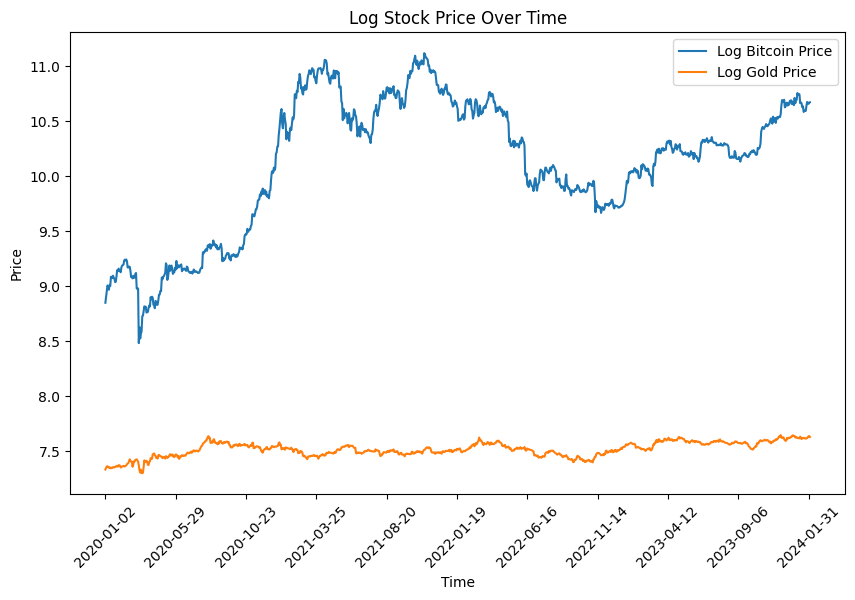

In [19]:
# Select the column for Bitcoin & Gold volatillity
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(df)), np.log(df['Bitcoin_Price']), label='Log Bitcoin Price')
ax.plot(range(len(df)), np.log(df['Gold_Price']), label='Log Gold Price')# Add labels, title, and legend
ax.set_xlabel('Time')
n = max(len(df) // 10, 1)  # Show about 10 ticks
ax.set_xticks(range(0, len(df), n))
ax.set_xticklabels(df['Time'][::n], rotation=45)
ax.set_ylabel('Price')
ax.set_title('Log Stock Price Over Time')
ax.legend()
plt.show()

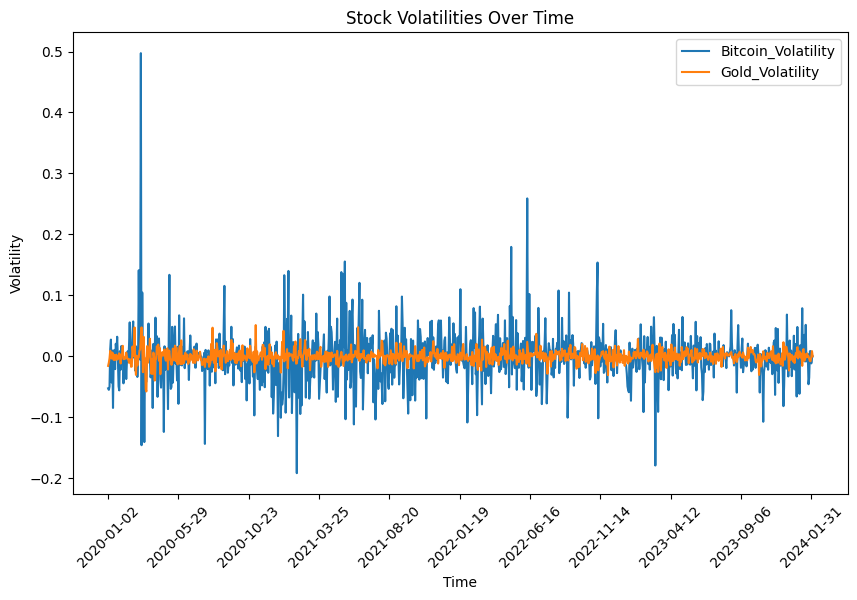

In [5]:
# Select the column for Bitcoin & Gold volatillity
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(len(df)), df['Bitcoin_Volatility'], label='Bitcoin_Volatility')
ax.plot(range(len(df)), df['Gold_Volatility'], label='Gold_Volatility')# Add labels, title, and legend
ax.set_xlabel('Time')
n = max(len(df) // 10, 1)  # Show about 10 ticks
ax.set_xticks(range(0, len(df), n))
ax.set_xticklabels(df['Time'][::n], rotation=45)
ax.set_ylabel('Volatility')
ax.set_title('Stock Volatilities Over Time')
ax.legend()

# Show the plot
plt.show()

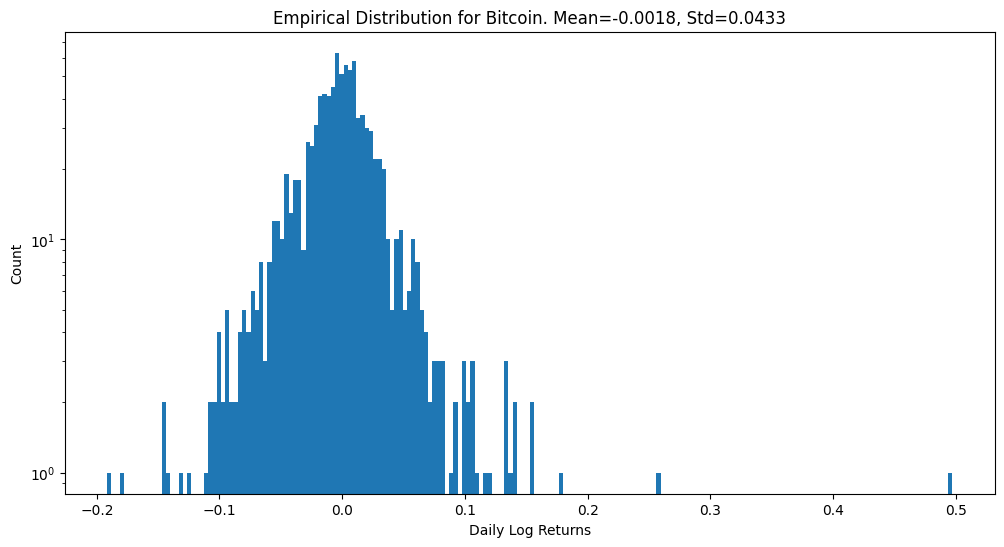

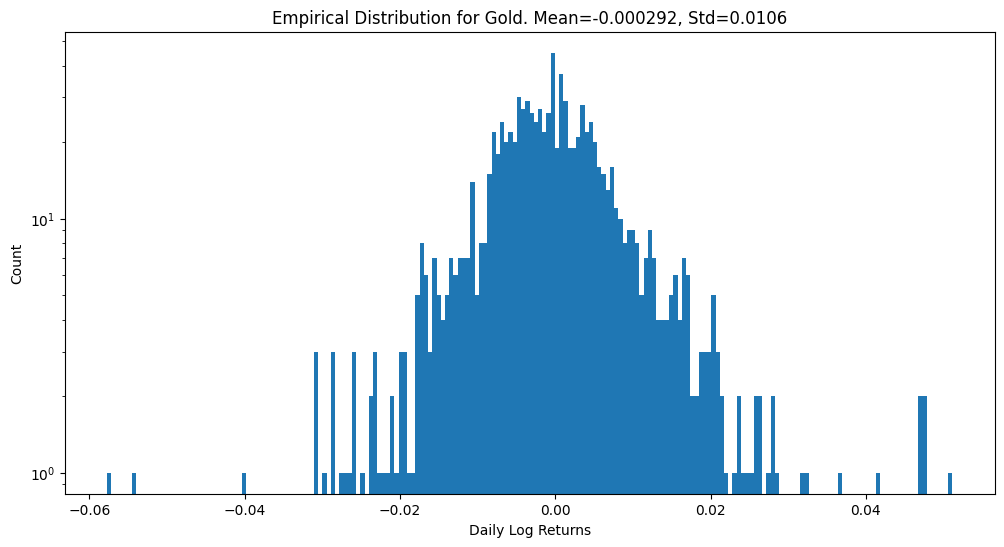

In [6]:
dates = df['Time'].to_numpy()
B_r = df['Bitcoin_Volatility'].to_numpy()
G_r = df['Gold_Volatility'].to_numpy()

B_r = torch.tensor(B_r).float()
G_r = torch.tensor(G_r).float()

# Histogram of daily log returns
plt.figure(figsize=(12, 6))
plt.hist(B_r.numpy(), bins=200)
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Daily Log Returns")
plt.title("Empirical Distribution for Bitcoin. Mean={:0.3g}, Std={:0.3g}".format(B_r.mean(), B_r.std()))
plt.show()
# Histogram of daily log returns
plt.figure(figsize=(12, 6))
plt.hist(G_r.numpy(), bins=200)
plt.yscale('log')
plt.ylabel("Count")
plt.xlabel("Daily Log Returns")
plt.title("Empirical Distribution for Gold. Mean={:0.3g}, Std={:0.3g}".format(G_r.mean(), G_r.std()))
plt.show()


In [7]:
def model(r):
    # Note we avoid plates because we'll later reparameterize along the time axis using
    # DiscreteCosineReparam, breaking independence. This requires .unsqueeze()ing scalars.
    h_0 = pyro.sample("h_0", dist.Normal(0, 1)).unsqueeze(-1)
    sigma = pyro.sample("sigma", dist.LogNormal(0, 1)).unsqueeze(-1)
    v = pyro.sample("v", dist.Normal(0, 1).expand(r.shape).to_event(1))
    log_h = pyro.deterministic("log_h", h_0 + sigma * v.cumsum(dim=-1))
    sqrt_h = log_h.mul(0.5).exp().clamp(min=1e-8, max=1e8)

    # Observed log returns, assumed to be a Stable distribution scaled by sqrt(h).
    r_loc = pyro.sample("r_loc", dist.Normal(0, 1e-2)).unsqueeze(-1)
    r_skew = pyro.sample("r_skew", dist.Uniform(-1, 1)).unsqueeze(-1)
    r_stability = pyro.sample("r_stability", dist.Uniform(0, 2)).unsqueeze(-1)
    pyro.sample("r", dist.Stable(r_stability, r_skew, sqrt_h, r_loc * sqrt_h, validate_args= False).to_event(1),
                obs=r)
# Stable reparam for efficiency
# Cosine reparam to capture long term correlations of v
reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})    

In [9]:
def fit_model(model,r, num_steps = 1000):
    optim = ClippedAdam({"lr": 0.05, "betas": (0.9, 0.99), "lrd": 0.1 ** (1 / num_steps)})
    guide = AutoDiagonalNormal(model)
    svi = SVI(model, guide, optim, Trace_ELBO())
    num_samples = 200
    losses = []
    stats = []
    log_vol = []
    for step in range(num_steps):
        loss = svi.step(r) / len(r)
        losses.append(loss)
        stats.append(guide.quantiles([0.325, 0.675]).items())
        if step % 10 == 0:
            try:
                with torch.no_grad():
                    pred = Predictive(model, guide=guide, num_samples=200, parallel=True)(r)
                    log_h = pred["log_h"]
                    log_vol.append(log_h)  # Append current log volatility

            except ValueError as e:
                print(f"ValueError at step {step}: {e}")
                continue  # Skip this step if an error occurs
            print("step {} loss = {:0.6g}".format(step, loss))

    return guide, losses, stats, log_vol

step 0 loss = 21.7004
step 10 loss = 7.81758
step 20 loss = 8.30617
step 30 loss = 4.68191
step 40 loss = 2.39368
step 50 loss = 5.54804
step 60 loss = 0.498947
step 70 loss = 0.489764
step 80 loss = -0.158913
step 90 loss = -0.322001
step 100 loss = -0.336128
step 110 loss = -0.768313
step 120 loss = -0.738782
step 130 loss = -0.175523
step 140 loss = -1.03235
step 150 loss = -1.04579
step 160 loss = -1.15924
step 170 loss = -1.29245
step 180 loss = -1.29162
step 190 loss = -1.27212
step 200 loss = -1.36402
step 210 loss = -1.41144
step 220 loss = -1.37084
step 230 loss = -1.38525
step 240 loss = -1.4511
step 250 loss = -1.39231
step 260 loss = -1.41035
step 270 loss = -1.50416
step 280 loss = -1.4283
step 290 loss = -1.45503
step 300 loss = -1.4634
step 310 loss = -1.44206
step 320 loss = -1.4665
step 330 loss = -1.48025
step 340 loss = -1.5009
step 350 loss = -1.49205
step 360 loss = -1.53362
step 370 loss = -1.50895
step 380 loss = -1.50967
step 390 loss = -1.56083
step 400 loss = 

(-1.6691428326430702, 20.0)

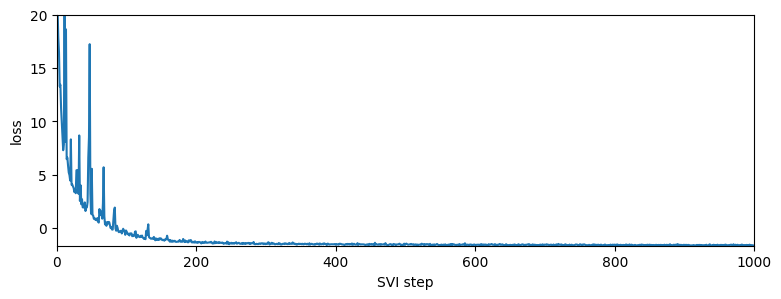

In [8]:
%%time
pyro.clear_param_store()
pyro.set_rng_seed(42)

guide, losses, stats, log_vol = fit_model(reparam_model, B_r)

plt.figure(figsize=(9, 3))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("SVI step")
plt.xlim(0, len(losses))
plt.ylim(min(losses), 20)

In [9]:
print("-" * 20)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

--------------------
h_0 = -1.174 ± 0.02585
r_loc = -0.0004179 ± 0.004791
r_skew = -2.542e-05 ± 0.001426
r_stability = 1.902 ± 0.008357
sigma = 0.4001 ± 0.001386


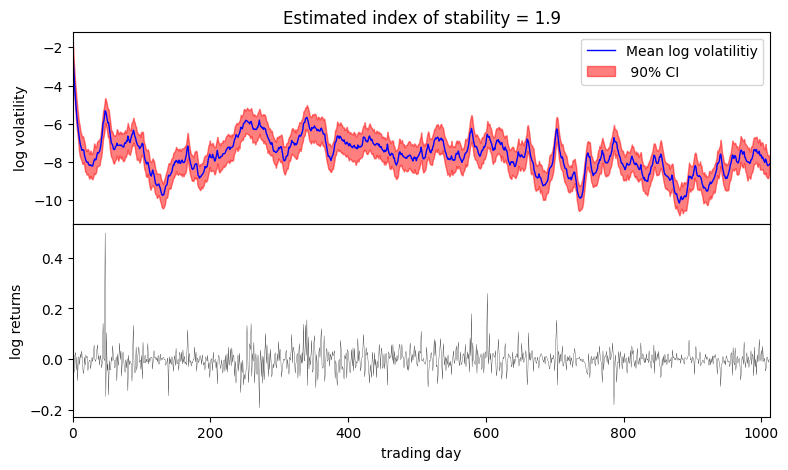

In [11]:
fig, axes = plt.subplots(2, figsize=(9, 5), sharex=True)
plt.subplots_adjust(hspace=0)
axes[1].plot(B_r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(B_r))

# We will pull out median log returns using the autoguide's .median() and poutines.
num_samples = 200
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=num_samples, parallel=True)(B_r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1, color = 'b', label = 'Mean log volatilitiy')
axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(int(num_samples * 0.1), dim=0).values,
                     log_h.kthvalue(int(num_samples * 0.9), dim=0).values,
                     color='red', alpha=0.5, label = " 90% CI")
axes[0].set_ylabel("log volatility")
axes[0].legend()
stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability))
axes[0].set_xlim(1,1013)

axes[1].set_xlabel("trading day");

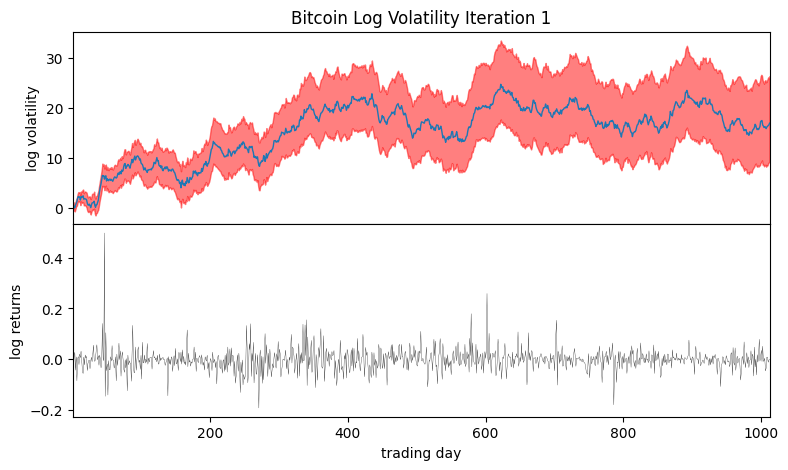

In [15]:
from matplotlib.animation import FuncAnimation

# Set up the figure and axis for the animation
fig, axes = plt.subplots(2, figsize=(9, 5), sharex=True)
plt.subplots_adjust(hspace=0)

# Function to update the plot
def update(frame):
    axes[0].clear()
    axes[1].clear()

    # Plot log volatility
    if frame < len(log_vol):
        axes[0].plot(log_vol[frame].median(0).values, lw=1)
        axes[0].fill_between(torch.arange(len(log_vol[frame][0])),
                             log_vol[frame].kthvalue(10, dim=0).values,
                             log_vol[frame].kthvalue(190, dim=0).values,
                             color='red', alpha=0.5)
        axes[0].set_ylabel("log volatility")

    # Plot log returns
    axes[1].plot(B_r, "k", lw=0.2)
    axes[1].set_ylabel("log returns")

    # Update title with current stability estimate
    axes[0].set_title(f"Bitcoin Log Volatility Iteration {frame + 1}")
    axes[1].set_xlabel("trading day")
    axes[0].set_xlim(1,1013)


# Create the animation
ani = FuncAnimation(fig, update, frames=len(log_vol), repeat=False)

# Show the animation
ani.save('Bitcoin_Volatility.gif', writer='pillow',fps = 5)

In [11]:
# Same analysis for Gold
pyro.clear_param_store()
pyro.set_rng_seed(42)
reparam_model = poutine.reparam(model, {"v": DiscreteCosineReparam(),
                                        "r": StableReparam()})    
guide, losses, stats, log_vol = fit_model(reparam_model, G_r)


step 0 loss = 21.7003
step 10 loss = 7.2721
step 20 loss = 30.1591
step 30 loss = 3.01064
step 40 loss = 1.29763
step 50 loss = 1.57698
step 60 loss = -0.558471
step 70 loss = -0.620884
step 80 loss = -1.47522
step 90 loss = -1.69212
step 100 loss = -1.84111
step 110 loss = -2.17349
step 120 loss = -2.18898
step 130 loss = -2.00584
step 140 loss = -2.47782
step 150 loss = -2.5663
step 160 loss = -2.5152
step 170 loss = -2.68195
step 180 loss = -2.63389
step 190 loss = -2.66032
step 200 loss = -2.66849
step 210 loss = -2.6217
step 220 loss = -2.6584
step 230 loss = -2.71896
step 240 loss = -2.78021
step 250 loss = -2.69167
step 260 loss = -2.73096
step 270 loss = -2.80248
step 280 loss = -2.73869
step 290 loss = -2.73208
step 300 loss = -2.76678
step 310 loss = -2.78491
step 320 loss = -2.80807
step 330 loss = -2.80093
step 340 loss = -2.80392
step 350 loss = -2.81251
step 360 loss = -2.83081
step 370 loss = -2.80762
step 380 loss = -2.75402
step 390 loss = -2.83519
step 400 loss = -2.8

(-2.9531204755779314, 20.0)

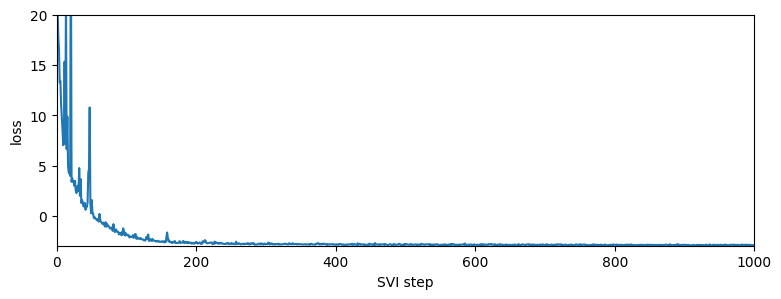

In [13]:

plt.figure(figsize=(9, 3))
plt.plot(losses)
plt.ylabel("loss")
plt.xlabel("SVI step")
plt.xlim(0, len(losses))
plt.ylim(min(losses), 20)

In [12]:
print("-" * 20)
for name, (lb, ub) in sorted(guide.quantiles([0.325, 0.675]).items()):
    if lb.numel() == 1:
        lb = lb.squeeze().item()
        ub = ub.squeeze().item()
        print("{} = {:0.4g} ± {:0.4g}".format(name, (lb + ub) / 2, (ub - lb) / 2))

--------------------
h_0 = -1.26 ± 0.02404
r_loc = 0.0005632 ± 0.004832
r_skew = 0.000243 ± 0.001471
r_stability = 1.959 ± 0.005908
sigma = 0.4956 ± 0.001221


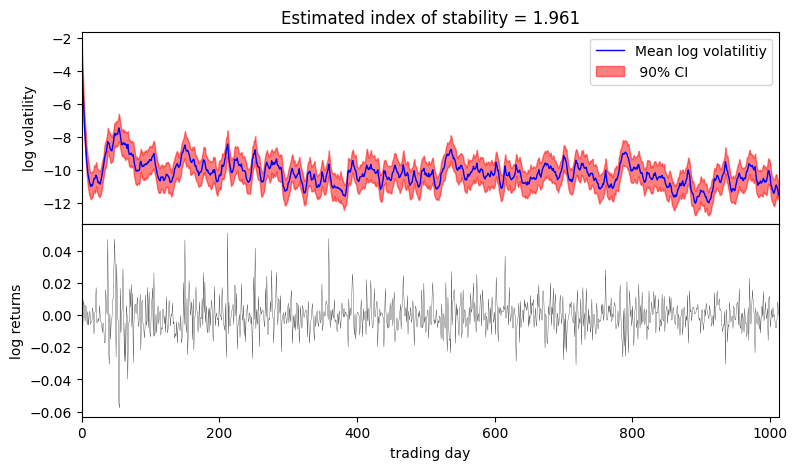

In [16]:
fig, axes = plt.subplots(2, figsize=(9, 5), sharex=True)
plt.subplots_adjust(hspace=0)
axes[1].plot(G_r, "k", lw=0.2)
axes[1].set_ylabel("log returns")
axes[1].set_xlim(0, len(G_r))

# We will pull out median log returns using the autoguide's .median() and poutines.
num_samples = 200
with torch.no_grad():
    pred = Predictive(reparam_model, guide=guide, num_samples=num_samples, parallel=True)(B_r)
log_h = pred["log_h"]
axes[0].plot(log_h.median(0).values, lw=1, color = 'b', label = 'Mean log volatilitiy')
axes[0].fill_between(torch.arange(len(log_h[0])),
                     log_h.kthvalue(int(num_samples * 0.1), dim=0).values,
                     log_h.kthvalue(int(num_samples * 0.9), dim=0).values,
                     color='red', alpha=0.5, label = " 90% CI")
axes[0].set_ylabel("log volatility")
axes[0].legend()
stability = pred["r_stability"].median(0).values.item()
axes[0].set_title("Estimated index of stability = {:0.4g}".format(stability))
axes[1].set_xlabel("trading day");